### Test_02 랜덤포레스트

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

- train.csv [파일]
```
ID : 샘플별 고유 ID
Age : 환자의 나이
Gender : 성별
Country : 국적
Race : 인종
Family_Background : 가족력 여부
Radiation_History : 방사선 노출 이력
Iodine_Deficiency : 요오드 결핍 여부
Smoke : 흡연 여부
Weight_Risk : 체중 관련 위험도
Diabetes : 당뇨병 여부
Nodule_Size : 갑상선 결절 크기
TSH_Result : TSH 호르몬 검사 결과
T4_Result : T4 호르몬 검사 결과
T3_Result : T3 호르몬 검사 결과
Cancer : 갑상선암 여부 (0: 양성, 1: 악성)
```

### 범주형 데이터인 변수
```
Gender : 성별
Country : 국적
Race : 인종
Family_Background : 가족력 여부
Radiation_History : 방사선 노출 이력
Iodine_Deficiency : 요오드 결핍 여부
Smoke : 흡연 여부
Weight_Risk : 체중 관련 위험도
Diabetes : 당뇨병 여부
```

In [11]:
# 학습 데이터
train = pd.read_csv('open/train.csv')
# 검증 데이터
test = pd.read_csv('open/test.csv')

In [13]:
train['Cancer'].value_counts(normalize=True)
# 0 : 양성, 1: 악성

Cancer
0    0.880001
1    0.119999
Name: proportion, dtype: float64

In [58]:
print('갑상선암 진단 학습 데이터셋 크기 : ', train.shape)
train.info()

갑상선암 진단 학습 데이터셋 크기 :  (87159, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87159 entries, 0 to 87158
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 87159 non-null  object 
 1   Age                87159 non-null  int64  
 2   Gender             87159 non-null  object 
 3   Country            87159 non-null  object 
 4   Race               87159 non-null  object 
 5   Family_Background  87159 non-null  object 
 6   Radiation_History  87159 non-null  object 
 7   Iodine_Deficiency  87159 non-null  object 
 8   Smoke              87159 non-null  object 
 9   Weight_Risk        87159 non-null  object 
 10  Diabetes           87159 non-null  object 
 11  Nodule_Size        87159 non-null  float64
 12  TSH_Result         87159 non-null  float64
 13  T4_Result          87159 non-null  float64
 14  T3_Result          87159 non-null  float64
 15  Cancer             87159 non-null  i

<Axes: >

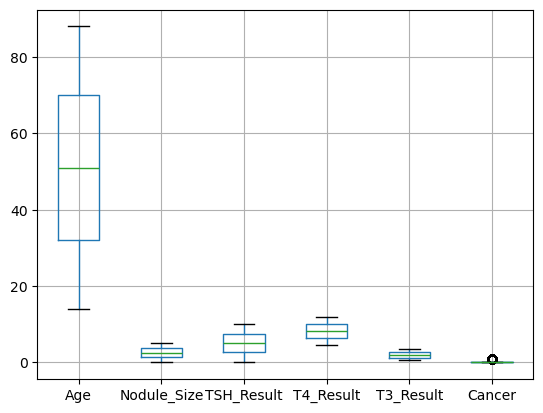

In [60]:
train.boxplot()

### 데이터 라벨링

In [68]:
all_data = pd.concat([train.drop(columns=['Cancer']), test], axis=0)
label_cols = ['Gender', 'Family_Background', 'Radiation_History',
              'Iodine_Deficiency', 'Smoke', 'Diabetes', 'Weight_Risk']

# 1. Label Encoding 적용할 컬럼
le = LabelEncoder()
for col in label_cols:
    all_data[col] = le.fit_transform(all_data[col].astype(str))

# 2. One-Hot Encoding 적용할 컬럼
one_hot_cols = ['Country', 'Race']

all_data = pd.get_dummies(all_data, columns=one_hot_cols)

# 다시 train/test로 분할
train_encoded = all_data.iloc[:len(train), :]
train_encoded['Cancer'] = train['Cancer'].values
test_encoded = all_data.iloc[len(train):, :]
train_encoded.columns

/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_10987/1645282988.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_encoded['Cancer'] = train['Cancer'].values


Index(['ID', 'Age', 'Gender', 'Family_Background', 'Radiation_History',
       'Iodine_Deficiency', 'Smoke', 'Weight_Risk', 'Diabetes', 'Nodule_Size',
       'TSH_Result', 'T4_Result', 'T3_Result', 'Country_BRA', 'Country_CHN',
       'Country_DEU', 'Country_GBR', 'Country_IND', 'Country_JPN',
       'Country_KOR', 'Country_NGA', 'Country_RUS', 'Country_USA', 'Race_AFR',
       'Race_ASN', 'Race_CAU', 'Race_HSP', 'Race_MDE', 'Cancer'],
      dtype='object')

In [19]:
x = train_encoded.drop(['ID', 'Cancer'], axis = 1)
y = train_encoded['Cancer']

x_train, x_test, y_train, y_test = train_test_split(x, y)

md = RandomForestClassifier()
md.fit(x_train, y_train)

pred = md.predict(x_test)

print('test f1score:', f1_score(y_test, pred, average='macro'))

test f1score: 0.6132513920007006


In [74]:
x = train_encoded.drop(['ID', 'Cancer'], axis = 1)
y = train_encoded['Cancer']
dum_test = test_encoded.drop('ID', axis=1)

# 스케일링
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y)

md = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced_subsample',
    random_state=42
)
md.fit(x_train, y_train)

pred = md.predict(x_test)

print('test f1score:', f1_score(y_test, pred, average='macro'))
print ('test accuracy:', accuracy_score(y_test, pred))

pred_test = md.predict(dum_test)

sumission = pd.DataFrame()
sumission['ID'] = test['ID']
sumission['Cancer'] = pred_test
# sumission.to_csv('sample_submission.csv', index = False, mode = 'a')

test f1score: 0.7102144335942571
test accuracy: 0.8849013308857274


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


```

---------------------------------------------------------------------------------------------
smote 적용


```

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score

# 1. 데이터 분리
x = train_encoded.drop(['ID', 'Cancer'], axis=1)
y = train_encoded['Cancer']
dum_test = test_encoded.drop('ID', axis=1)

# 2. 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# 3. 모델과 RandomizedSearchCV 설정
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,  # 실험 횟수
    scoring='f1_macro',  # 평가 지표
    cv=5,  # 교차 검증 folds 수
    random_state=42,
    n_jobs=-1  # 가능한 모든 코어 사용
)

# 4. 하이퍼파라미터 탐색 수행
search.fit(x, y)
best_model = search.best_estimator_

# 5. 성능 평가용으로 train/test 분리 후 평가
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
best_model.fit(x_train, y_train)
pred = best_model.predict(x_test)
print('test f1score:', f1_score(y_test, pred, average='macro'))

# 6. 최종 예측 후 제출 파일 생성
pred_test = best_model.predict(dum_test)

submission = pd.DataFrame({
    'ID': test['ID'],
    'Cancer': pred_test
})
# submission.to_csv('sample_submission.csv', index=False)

# 7. 최고 성능 파라미터 출력
print('Best Parameters:', search.best_params_)


NameError: name 'train_encoded' is not defined

##### smote를 했을 때 f1 score가 더 떨어지는 경향 존재 -> 안써야겠다

In [26]:
from imblearn.ensemble import BalancedRandomForestClassifier

x = train_encoded.drop(['ID', 'Cancer'], axis = 1)
y = train_encoded['Cancer']
dum_test = test_encoded.drop('ID', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y)

model = BalancedRandomForestClassifier(n_estimators=300, random_state=42)
model.fit(x_train, y_train)

pred = md.predict(x_test)

print('test f1score:', f1_score(y_test, pred, average='macro'))


/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


test f1score: 0.6646154918723708
